# 💡How to adress imbalanced data through predictive maintenance ML example👀

## 1. Setup

In [1]:
!pip install pyod

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe
from pyod.models.hbos import HBOS

In [3]:
df = pd.read_csv("ai4i2020.csv")
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


## 2. Preprocess the dataset

In [4]:
for col in df.columns:
    print(col, sum(df[col]==""))
df.describe()
train_data = df.drop(["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"], axis=1)

UDI 0
Product ID 0
Type 0
Air temperature [K] 0
Process temperature [K] 0
Rotational speed [rpm] 0
Torque [Nm] 0
Tool wear [min] 0
Machine failure 0
TWF 0
HDF 0
PWF 0
OSF 0
RNF 0


## 3. Scaling & Encoding

In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
encoder = LabelEncoder()
scaler = MinMaxScaler()
continuous_cols = list(train_data.columns)
continuous_cols.remove("Type")
continuous_cols.remove("Machine failure")
train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])

for col in train_data.columns:
    if col not in continuous_cols:
        train_data[col] = encoder.fit_transform(train_data[col])

In [6]:
train_data.dtypes

Type                         int32
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
Machine failure              int64
dtype: object

## 4. Looking at the distribution

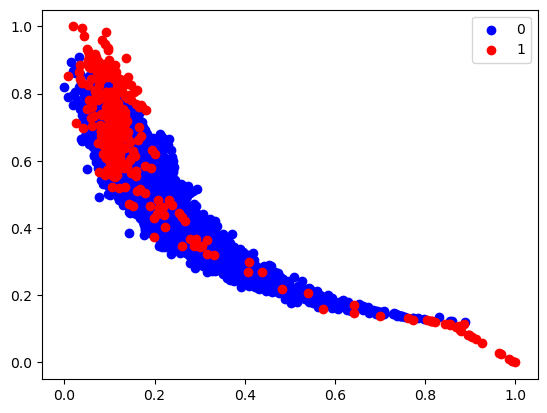

In [7]:
# Plot the unsampled distribution
import matplotlib.pyplot as plt
from collections import Counter

# Compter les occurrences de chaque label
counter = Counter(train_data["Machine failure"])
# Create a new figure object
fig_unsampled = plt.figure()
# Parcourir chaque label et tracer le scatter plot correspondant
for label, cnt in counter.items():
    row_id = np.where(train_data['Machine failure'] == label)[0]
    # Spécifier la couleur en fonction de la valeur de "Machine failure"
    if label == 0:
        plt.scatter(train_data.iloc[row_id, 3], train_data.iloc[row_id, 4], label=str(label), color='blue')
    elif label == 1:
        plt.scatter(train_data.iloc[row_id, 3], train_data.iloc[row_id, 4], label=str(label), color='red')
# Afficher la légende
plt.legend()
# Afficher le graphique
plt.show()


In [8]:
# Adjust the imbalances
over = SMOTENC(categorical_features=[0], sampling_strategy=0.25)
under = RandomUnderSampler(sampling_strategy=0.5)
pipeline = pipe(steps=[('o', over), ('u', under)])
X = train_data.drop('Machine failure', axis=1)
y = train_data['Machine failure']
x_cols = X.columns
X, y = pipeline.fit_resample(X, y)

In [9]:
# Plot the sampled distribution

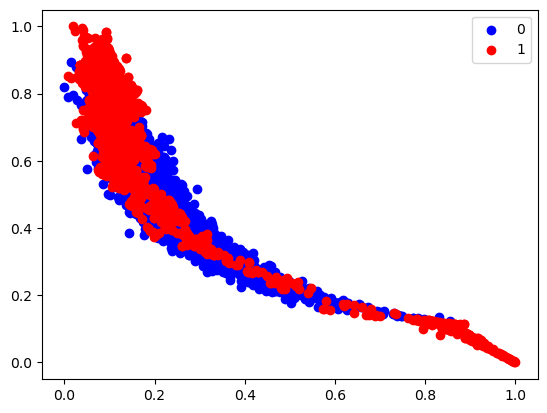

In [10]:
sampled_counter = Counter(y)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
# Parcourir chaque label et tracer le scatter plot correspondant
for label, cnt in sampled_counter.items():
    row_id = np.where(y == label)[0]
    # Spécifier la couleur en fonction de la valeur de "Machine failure"
    if label == 0:
        plt.scatter(X.iloc[row_id, 3], X.iloc[row_id, 4], label=str(label), color='blue')
    elif label == 1:
        plt.scatter(X.iloc[row_id, 3], X.iloc[row_id, 4], label=str(label), color='red')
# Afficher la légende
plt.legend()
# Afficher le graphique
plt.show()

## 5. Create, fit and test the model 

In [11]:
# # Create Histogram Based Outliers Score model
# contamination_percent = 0.3333
# clf_name = "HBOS"
# clf = HBOS(contamination = contamination_percent)

# # Train the model
# clf.fit(X)

# # Evaluate the model
# pred = clf.labels_
# predicted_yes = X[pred==1]
# predicted_no = X[pred==0]
# outliers_predicted = sum(pred==1)
# nonoutliers_predicted = sum(pred==0)
# failure = y[y==1]
# non_failure = y[y==0]
# idx1 = predicted_yes.index.intersection(failure.index)
# idx2 = predicted_no.index.intersection(non_failure.index)

# wrong_preds = X.shape[0] - failure.loc[idx1].shape[0] - non_failure.loc[idx2].shape[0]

# wrong_pct = np.round(((wrong_preds)/X.shape[0])*100, 3)
# right_pct = np.round(100-wrong_pct, 3)

In [12]:

# Create Histogram Based Outliers Score model
contamination_percent = 0.3333
clf = HBOS(contamination=contamination_percent)

# Train the model
clf.fit(X)

# Evaluate the model
pred = clf.predict(X)

predicted_yes = X[pred == 1]
predicted_no = X[pred == 0]
outliers_predicted = sum(pred == 1)
nonoutliers_predicted = sum(pred == 0)

# Assuming 'y_ground_truth' is a pandas Series or numpy array containing the ground truth labels
idx1 = np.intersect1d(np.where(pred == 1)[0], np.where(y == 1)[0])
idx2 = np.intersect1d(np.where(pred == 0)[0], np.where(y == 0)[0])

wrong_preds = X.shape[0] - len(idx1) - len(idx2)
wrong_pct = np.round((wrong_preds / X.shape[0]) * 100, 3)
right_pct = np.round(100 - wrong_pct, 3)



In [13]:
# Print the HBOS model evaluation results
print("HBOS Model Evaluation:")
print("Number of predicted outliers:", outliers_predicted)
print("Number of predicted non-outliers:", nonoutliers_predicted)
print("Number of misclassified instances:", wrong_preds)
print("Percentage of misclassified instances: {}%".format(wrong_pct))
print("Percentage of correctly classified instances: {}%".format(right_pct))



HBOS Model Evaluation:
Number of predicted outliers: 2415
Number of predicted non-outliers: 4830
Number of misclassified instances: 2588
Percentage of misclassified instances: 35.721%
Percentage of correctly classified instances: 64.279%


# 6. Further insights and outliers suppression

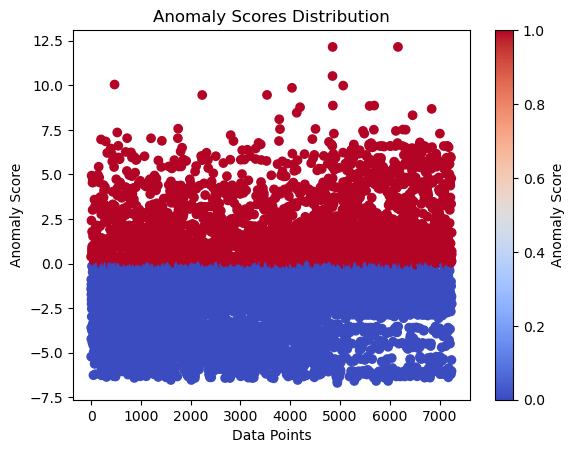

Statistics of Outlier Data:
              Type  Air temperature [K]  Process temperature [K]  \
count  2415.000000          2415.000000              2415.000000   
mean      1.052174             0.537542                 0.539223   
std       0.342650             0.265864                 0.222333   
min       0.000000             0.000000                 0.012346   
25%       1.000000             0.304582                 0.345679   
50%       1.000000             0.554348                 0.555556   
75%       1.000000             0.784158                 0.728395   
max       2.000000             0.989130                 0.987654   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
count             2415.000000  2415.000000      2415.000000  
mean                 0.274581     0.506340         0.477502  
std                  0.232090     0.253818         0.275339  
min                  0.000000     0.000000         0.000000  
25%                  0.094987     0.309066       

In [19]:
anomaly_scores = clf.decision_scores_

plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=pred, cmap='coolwarm')
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Scores Distribution")
plt.xlabel("Data Points")
plt.ylabel("Anomaly Score")
plt.show()

# Explore the characteristics of outliers
outlier_data = X[pred == 1]
outlier_stats = outlier_data.describe()
print("Statistics of Outlier Data:")
print(outlier_stats)

# Further analysis and investigation of outliers
# You can examine specific features or patterns within the outliers, compare them with non-outliers,
# and identify potential factors contributing to their abnormal behavior.

# Additional EDA steps, such as data visualization, feature analysis, and pattern discovery,
# can be performed using various techniques and libraries depending on your specific requirements.

# Conclude the EDA with summary findings and insights gained from the HBOS analysis.


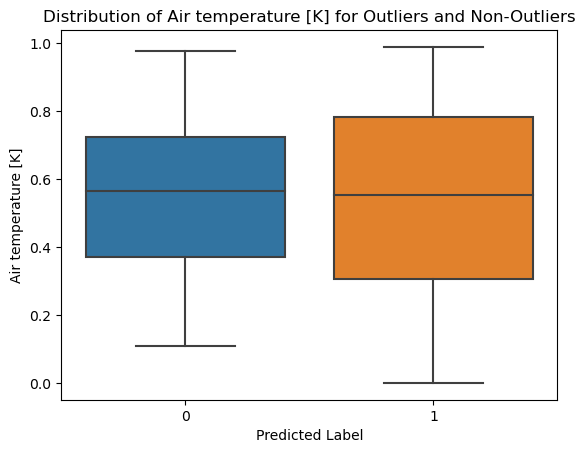

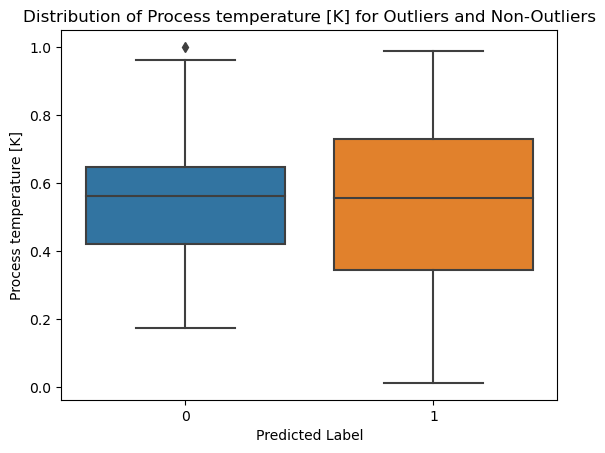

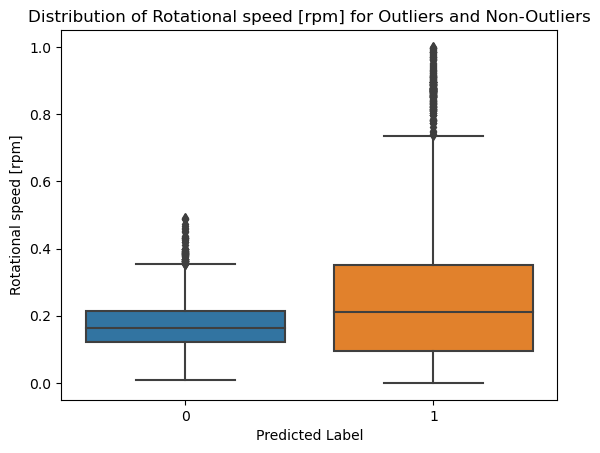

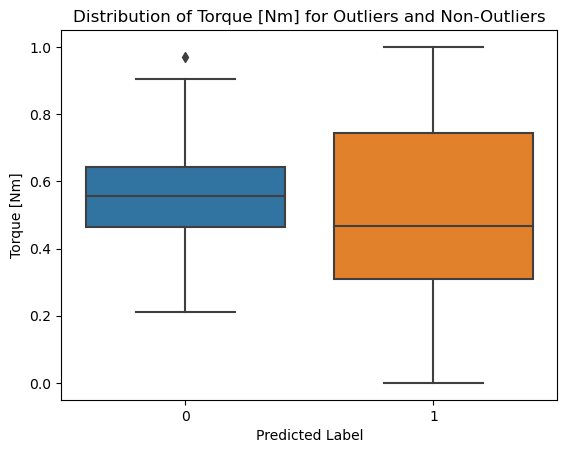

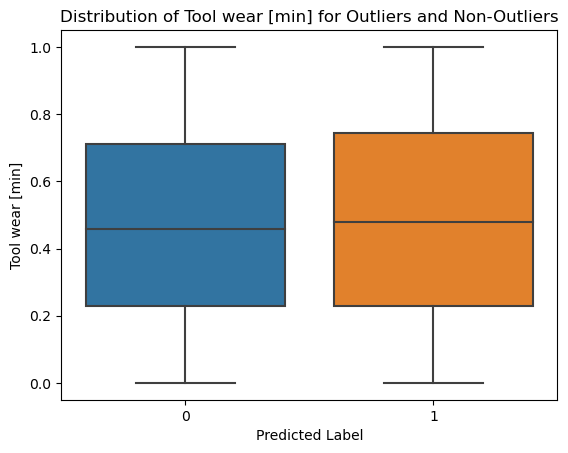

In [43]:
# Set a safe threshold for classifying outliers
safe_threshold = 0.75  # Adjust the threshold value based on the anomaly score distribution and desired level of safety

# Identify outliers based on the safe threshold
outliers = X[anomaly_scores >= safe_threshold]
non_outliers = X[anomaly_scores < safe_threshold]

# Remove outliers from the dataset
filtered_data = X[anomaly_scores < safe_threshold]

# Further analysis and investigation of outliers
# You can examine specific features or patterns within the outliers, compare them with non-outliers,
# and identify potential factors contributing to their abnormal behavior.

# Example: Visualize specific features for outliers and non-outliers
import seaborn as sns

# Get the list of all features in your dataset (excluding the label column if present)
features_of_interest = X.drop('Type', axis=1).columns.tolist()

# Iterate over all features for analysis
for feature in features_of_interest:
    sns.boxplot(x=pred, y=X[feature])
    plt.xlabel("Predicted Label")
    plt.ylabel(feature)
    plt.title("Distribution of {} for Outliers and Non-Outliers".format(feature))
    plt.show()

In [54]:
# Conclude the EDA with summary findings and insights gained from the HBOS analysis
# Summarize any notable patterns, differences between outliers and non-outliers, and potential factors contributing to abnormal behavior.

# Calculate summary statistics for outliers and non-outliers
outlier_stats = outliers.describe()
non_outlier_stats = non_outliers.describe()

# Calculate the contribution of each feature to abnormal behavior
factor_contributions = {}

for feature in features_of_interest:
    outlier_mean = outlier_stats.loc['mean', feature]
    non_outlier_mean = non_outlier_stats.loc['mean', feature]
    contribution = outlier_mean - non_outlier_mean
    factor_contributions[feature] = contribution

# Sort the factor contributions in descending order
sorted_contributions = sorted(factor_contributions.items(), key=lambda x: x[1], reverse=True)

# Classify the features based on their contribution to abnormal behavior
classification = {}

for i, (feature, contribution) in enumerate(sorted_contributions):
    if i < len(sorted_contributions) * 0.2:  # Classify the top 20% as the most potential factors
        classification[feature] = "Most Potential"
    else:
        classification[feature] = "Other"
        
# Print summary findings and insights
print("Summary Findings:")
print("Number of outliers detected:", len(outliers))
print("Number of non-outliers:", len(non_outliers))
print("Contributions of features to abnormal behavior:")
for feature, contribution in sorted_contributions:
    print(f"{feature}: {contribution}")
print("\nFeature Classification:")
for feature, category in classification.items():
    print(f"{feature}: {category}")

Summary Findings:
Number of outliers detected: 1721
Number of non-outliers: 5524
Contributions of features to abnormal behavior:
Rotational speed [rpm]: 0.13490489799808641
Process temperature [K]: 0.00279343935895382
Tool wear [min]: 0.0010672632391960923
Air temperature [K]: -0.010762999437932685
Torque [Nm]: -0.07426747384588228

Feature Classification:
Rotational speed [rpm]: Most Potential
Process temperature [K]: Other
Tool wear [min]: Other
Air temperature [K]: Other
Torque [Nm]: Other


In [46]:
print("Before outliers suppression:",X.shape)
print("Atfer outliers suppression :",filtered_data.shape)

Before outliers suppression: (7245, 6)
Atfer outliers suppression : (5524, 6)
